# Changed
v3 = 0.01


# Knowledge Assembly

In [178]:
# for nellinetworkconjunctive
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)  

from nellinetworkconjunctivev2 import Network
from helpers import fit_sigmoid, mean_squared_error, rotate, load_behavioural_data
from plotting import plotting_init, matrix_plot, mds_plot

import torch
import numpy as np
from scipy.special import expit
from sklearn import manifold
from sklearn.metrics import euclidean_distances

import matplotlib.pyplot as plt
import seaborn as sns

from multiprocessing import Pool

## Load behavioural data

In [179]:
midd_performance, high_performers, low_performers = load_behavioural_data("../behavioural-data/")

## Set simulation mode

In [180]:
mode = "main" # "lazy-regime", "two-readouts", "fixed-inputs"
mode2 = "main"

## Set Hyperparameters

In [181]:
# Random seeds
seeds_n = 10
mds_seed = 1

# Number of input items
items_n = 7

# Experiment details
training_blocks = 1
trials = 3000
training_length = training_blocks * trials
# stitching_steps = 20

# Network hyperparameters
readouts = 2 if mode == "two-readouts" else 1
h1_size = 20

if mode == "lazy-regime":
    w1_weight_std = np.sqrt(6. / items_n)
    w2_weight_std = np.sqrt(10. / h1_size)
else:
    w1_weight_std = 0.025 * np.sqrt(1 / items_n)
    w2_weight_std = np.sqrt(1 / h1_size)

proportion = 1e6  
    
if mode2 == "lazy-regime":
    w3_weight_std = np.sqrt(6. / items_n)
    w4_weight_std = np.sqrt(10. / h1_size)
else:
    w3_weight_std = 0.025 * np.sqrt(1 / items_n) / proportion
    w4_weight_std = np.sqrt(1 / h1_size) / proportion

learning_rate = 1e-2
# learning_rate = 0.03 if mode == "lazy-regime" else 0.05
learning_rate_layers_3_4 = 1e-3

# Parameter space for gridsearch
gammas = np.concatenate([[0], np.geomspace(1e-4, 1, 69)])
ss = np.geomspace(1e-2, 100, 65)

In [182]:
print(w1_weight_std)
print(w3_weight_std)

0.00944911182523068
9.44911182523068e-09


# TI Exp with conjunctive population

In [183]:
def train_networks_exp(gamma):
    # Log
    results = {
        "train": {
            "losses": np.zeros((seeds_n, training_length)),
            "w1s": np.zeros((seeds_n, training_length, h1_size, items_n)),
            "w2s": np.zeros((seeds_n, training_length, readouts, h1_size)),
            "h1s": np.zeros((seeds_n, training_length, items_n, h1_size)),
            "certainties": np.zeros((seeds_n, training_length, items_n, items_n)),
            "evals": np.zeros((seeds_n, items_n, items_n)),
        },
    }
    
    results["train"]["training_progress"] = np.zeros((seeds_n, training_length, items_n, items_n))
    
    for seed in range(seeds_n):
        np.random.seed(seed)
        torch.manual_seed(seed)

        # Init Network
        model = Network(items_n, h1_size, w1_weight_std, w2_weight_std, w3_weight_std, w4_weight_std, readouts=readouts)
        criterion = torch.nn.MSELoss()
        optimiser = torch.optim.SGD([
            {'params': [*model.layer_1.parameters(), *model.layer_2.parameters()], 'lr': learning_rate},
            {'params': [*model.layer_3.parameters(), *model.layer_4.parameters()], 'lr': learning_rate_layers_3_4}
        ])

        training_step = 0
        items_per_context = items_n
        
        for block in range(training_blocks): 
            items_per_context = 7
            p = 4
            q = 2
            training_pairs_norm = np.asarray(list(zip(range(0, items_per_context - 1), range(1, items_per_context))))
            training_pairs_exp = np.asarray([[p,q]])
            training_pairs = np.concatenate([training_pairs_norm, training_pairs_exp], axis=0)
            for trial in range(trials):
                # Sample input and target
                random_index = np.random.randint(0, len(training_pairs))
                item_1, item_2 = np.random.choice(training_pairs[random_index], 2, False)
                if readouts == 1:
                    if item_1 == p and item_2 == q or item_1 == q and item_2 == p:
                        exception = True
                    else:
                        exception = False
                    if not exception:
                        target = torch.tensor([1. if item_1 > item_2 else -1.])
                    else:
                        target = torch.tensor([-1. if item_1 > item_2 else 1.])

                #UNCHANGED SO FAR
                elif readouts == 2:
                    target = torch.tensor([1., -1.] if item_1 > item_2 else [-1., 1.])


                # Forward propagate and backpropagate
                optimiser.zero_grad()
                _, output = model(item_1, item_2)
                model.loss = criterion(output, target)
                model.loss.backward()
                model.correct(learning_rate, gamma)
                optimiser.step()

                # Log
                with torch.no_grad():
                    results["train"]["losses"][seed, training_step] = model.loss.item()
                    results["train"]["w1s"][seed, training_step] = model.layer_1.weight.detach().numpy().copy()
                    results["train"]["w2s"][seed, training_step] = model.layer_2.weight.detach().numpy().copy()
                    results["train"]["h1s"][seed, training_step] = model.extract_h1s()
                    results["train"]["certainties"][seed, training_step] = model.pairwise_certainty.a.copy()
                    results["train"]["training_progress"][seed, training_step] = model.evaluate()
                
                training_step += 1
        
        # Evaluate
        with torch.no_grad():
            results["train"]["evals"][seed] = model.evaluate()
        
    return gamma, results



In [184]:
results = train_networks_exp(.1)

# Check the convergence

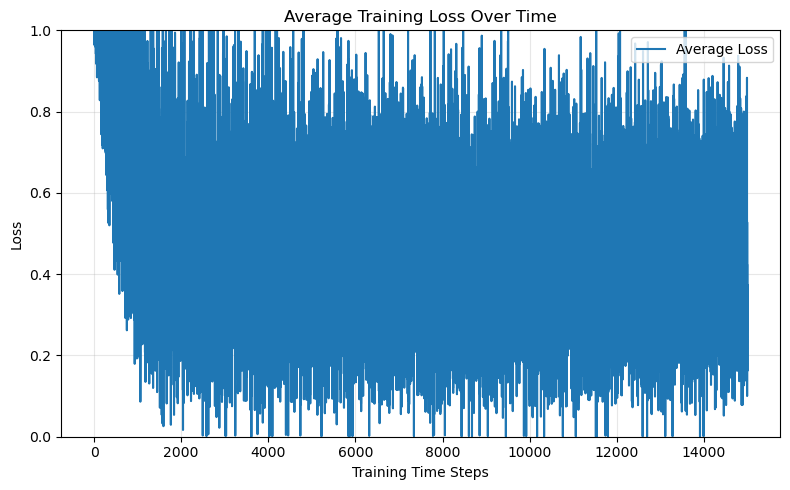

In [185]:
import matplotlib.pyplot as plt

# Plot the average loss across all seeds during training
if isinstance(results, tuple):
    results = results[1]
losses = results["train"]["losses"]  # shape: (seeds_n, training_steps)
avg_loss = losses.mean(axis=0)
plt.figure(figsize=(8, 5))
plt.plot(avg_loss, label='Average Loss')
plt.xlabel("Training Time Steps")
plt.ylabel("Loss")
plt.title("Average Training Loss Over Time")
plt.legend()
plt.ylim(0,1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


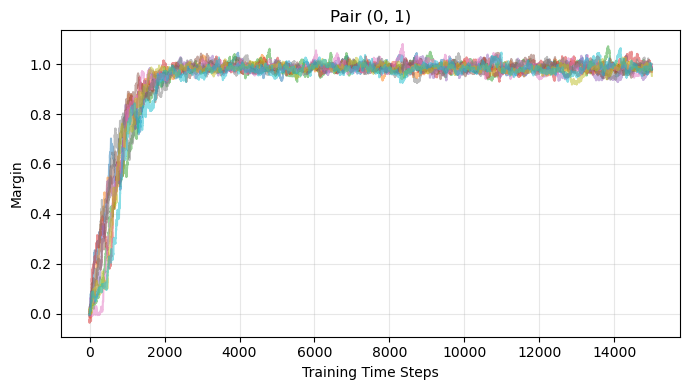

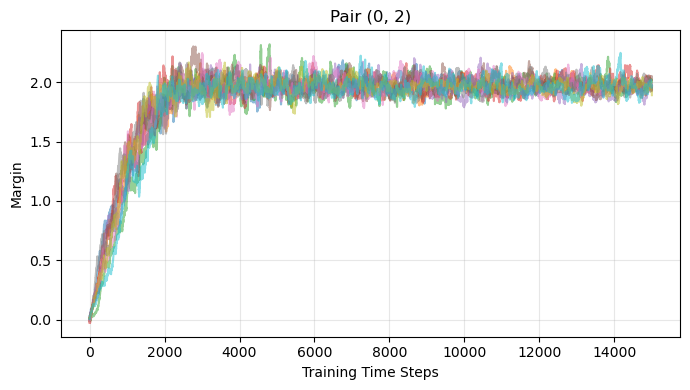

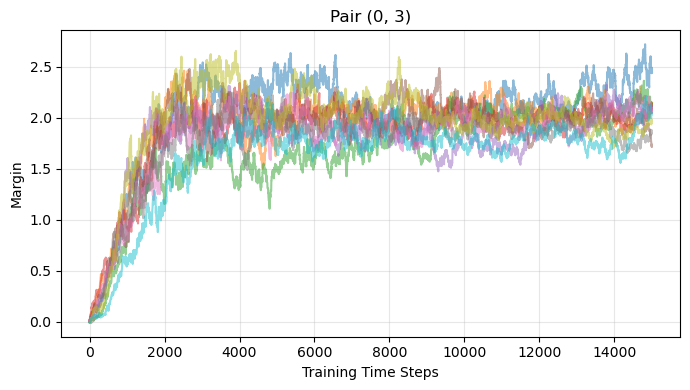

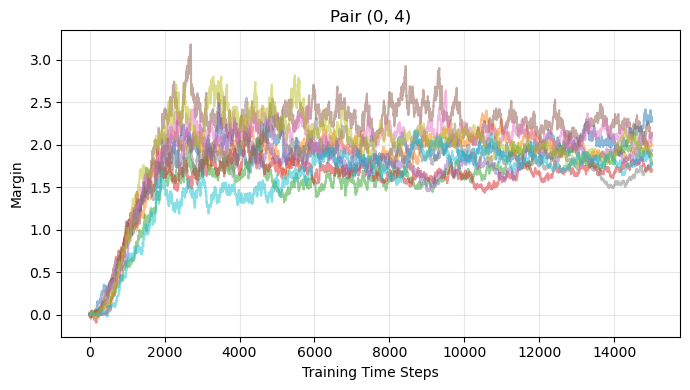

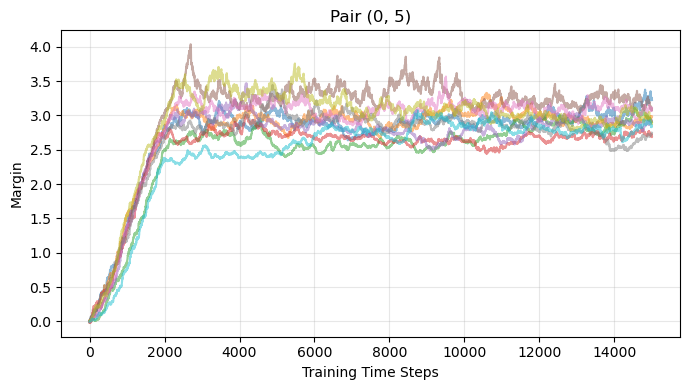

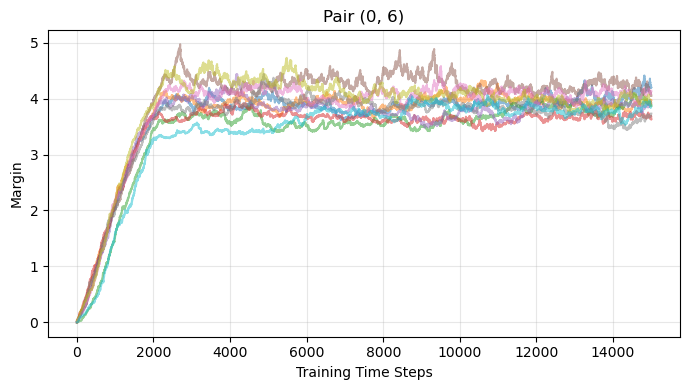

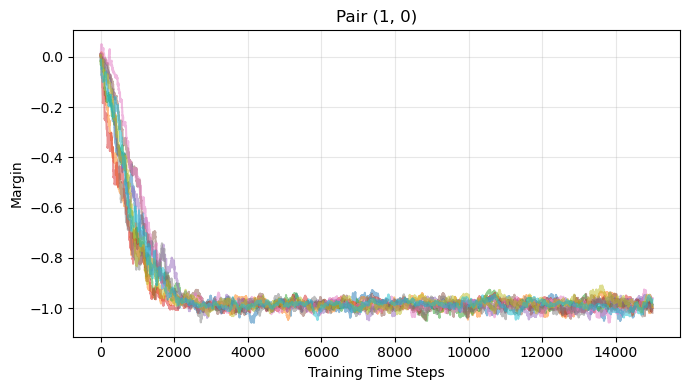

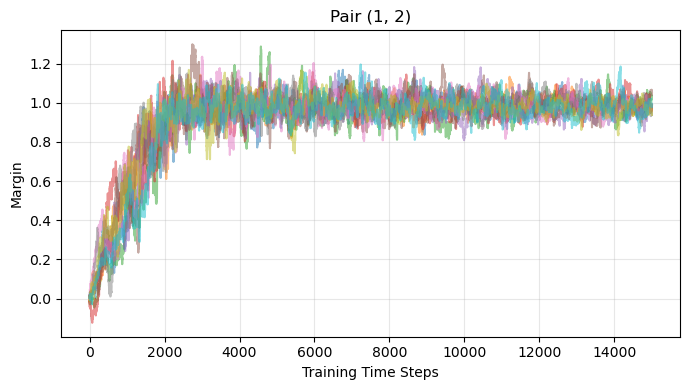

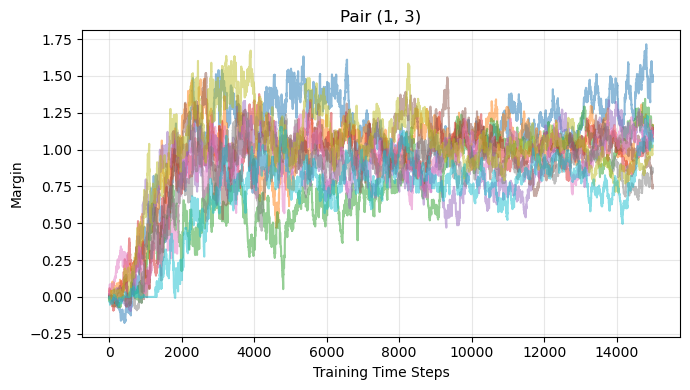

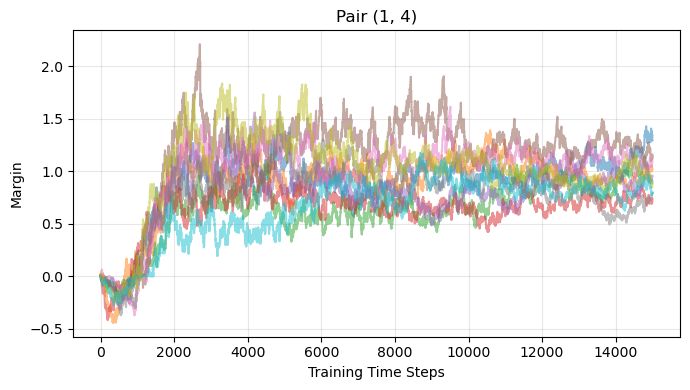

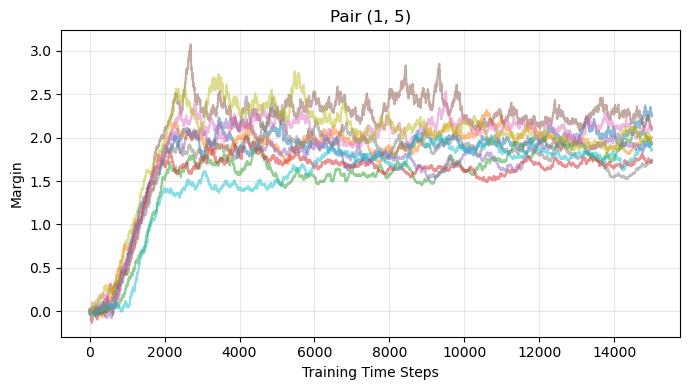

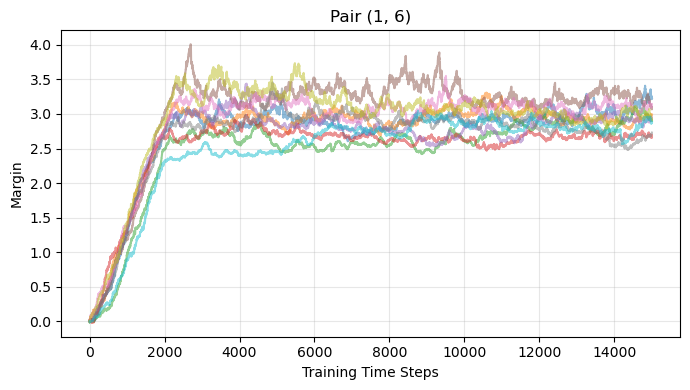

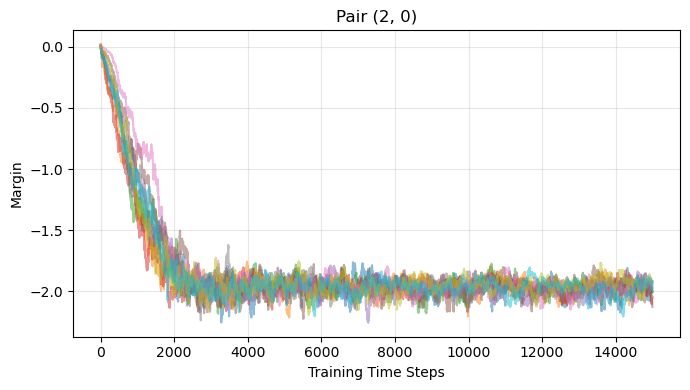

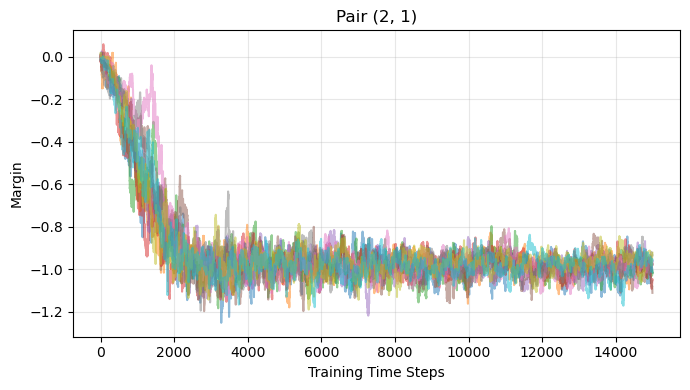

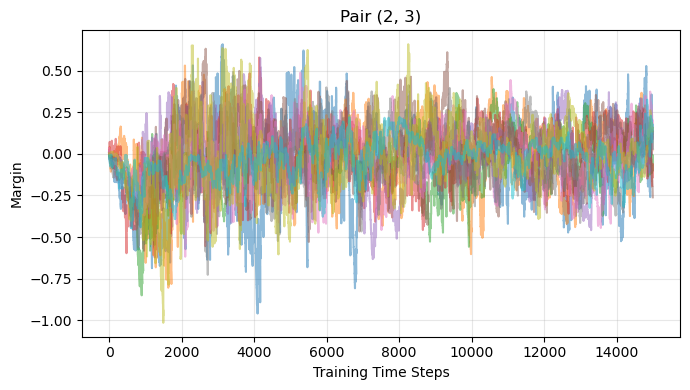

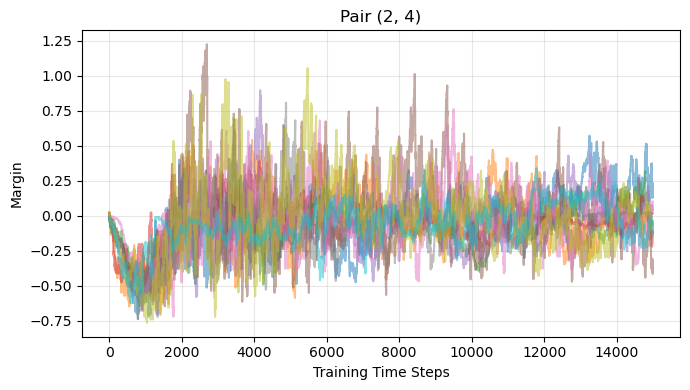

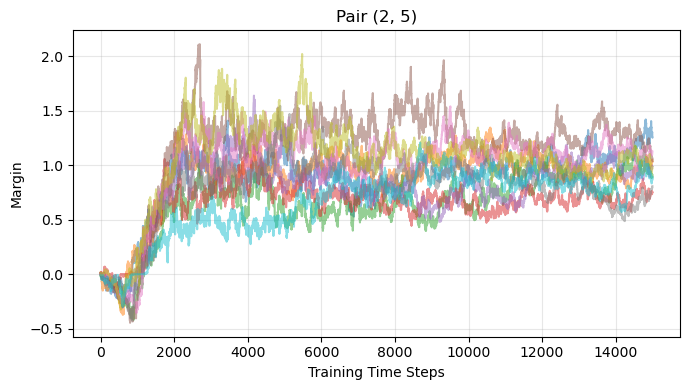

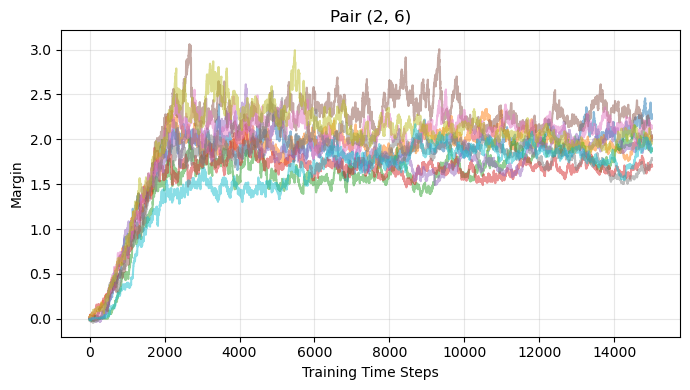

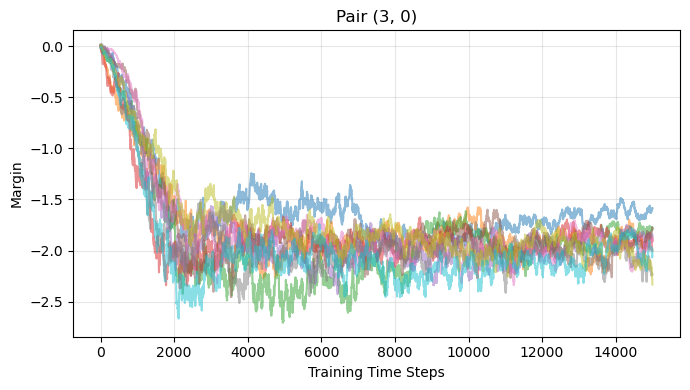

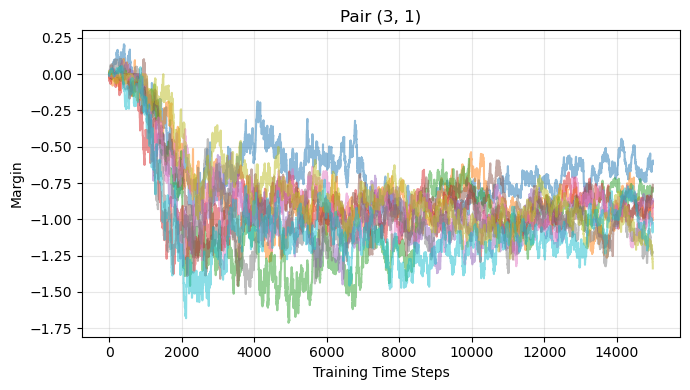

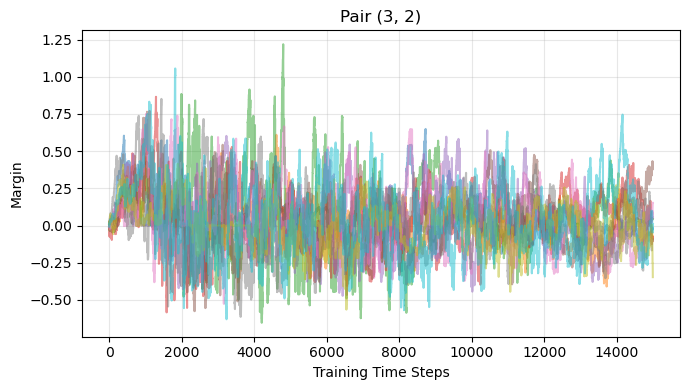

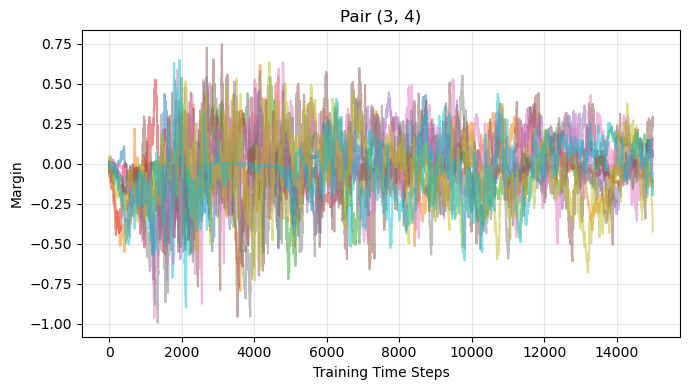

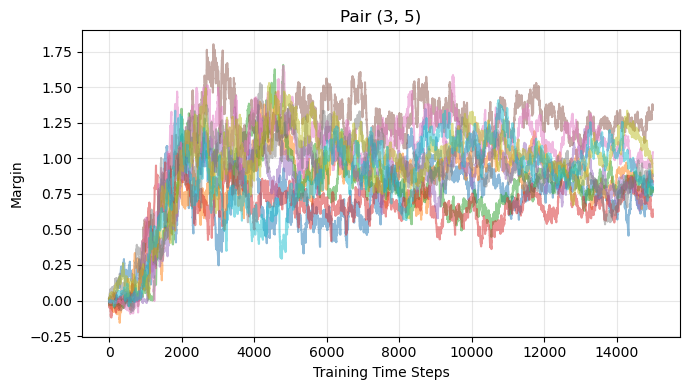

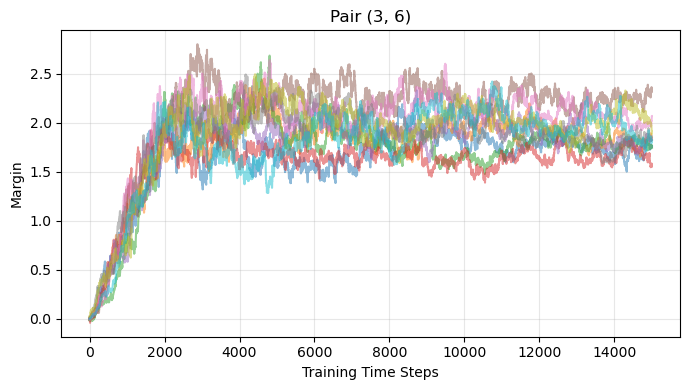

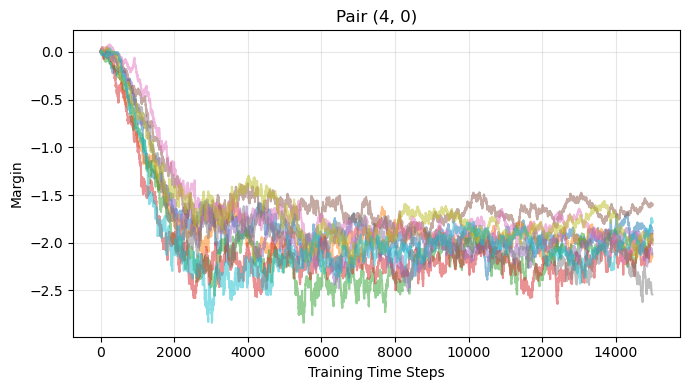

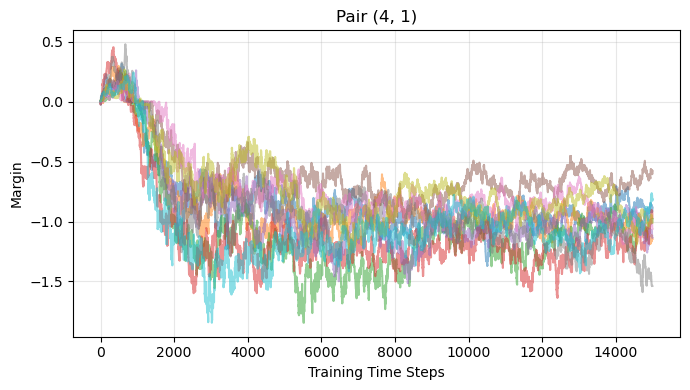

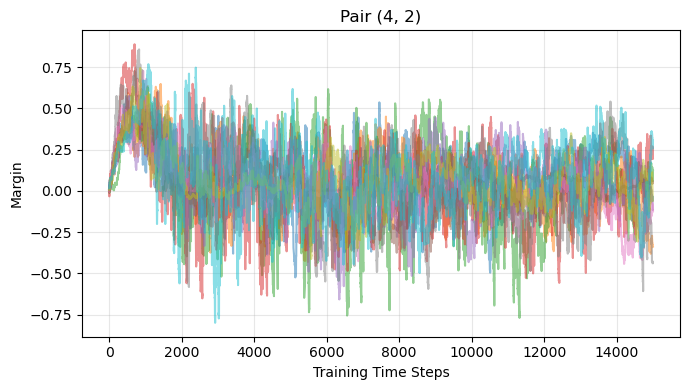

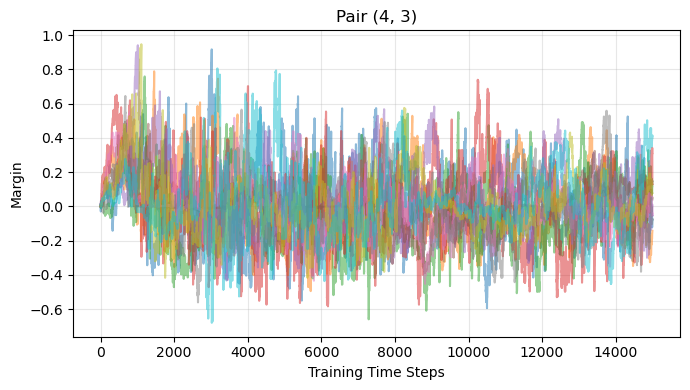

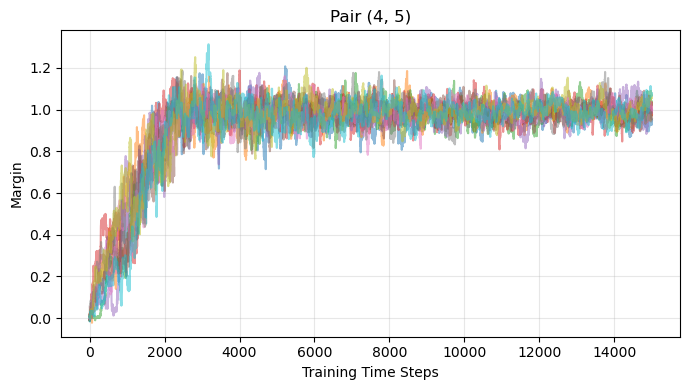

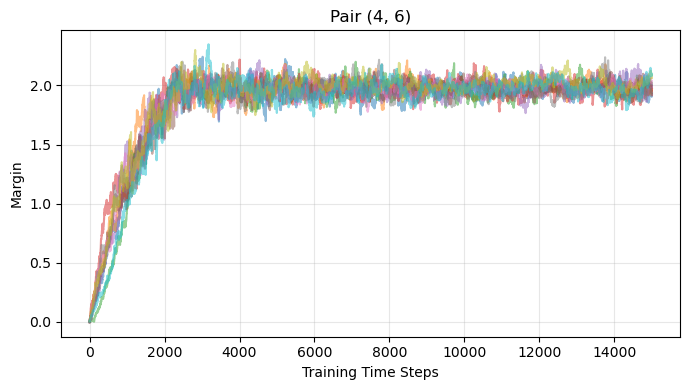

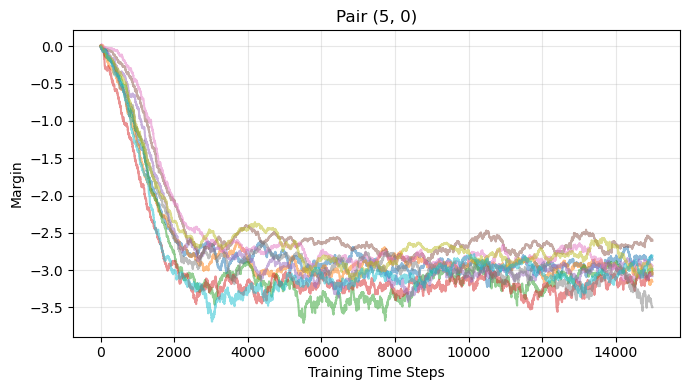

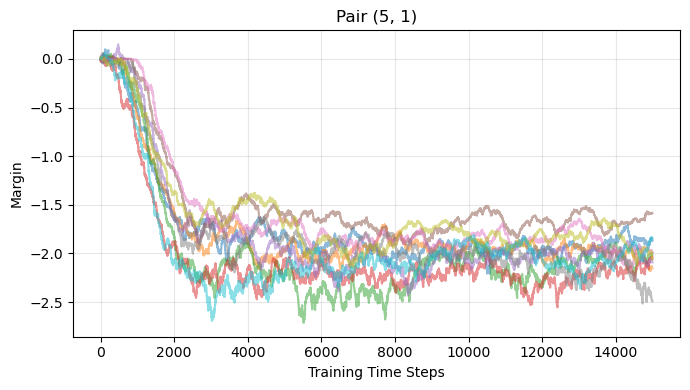

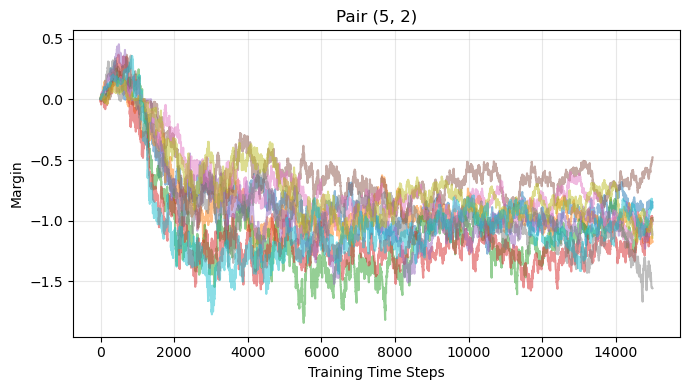

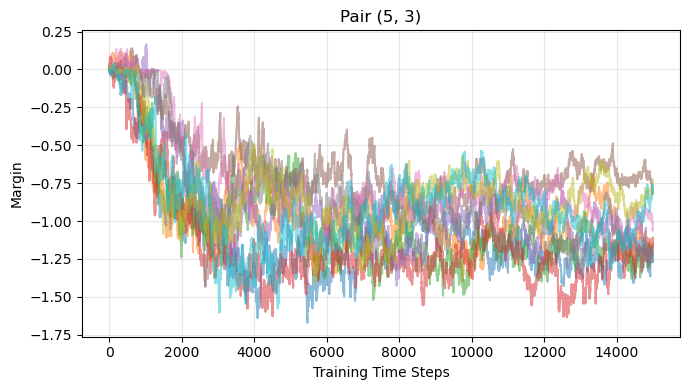

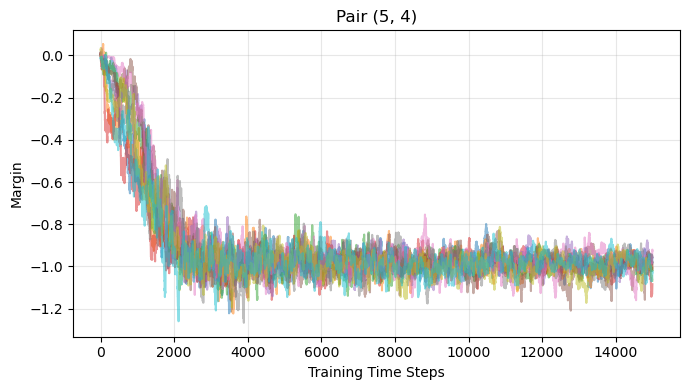

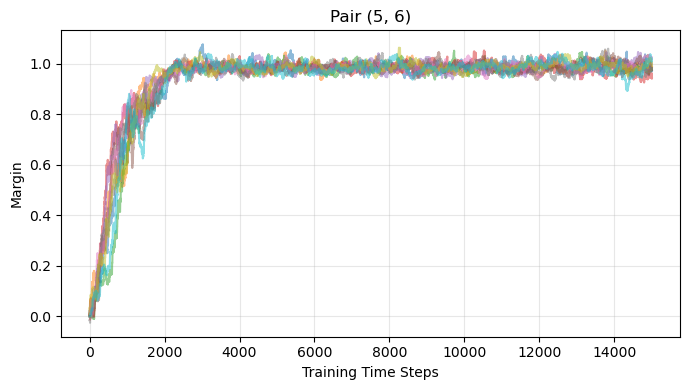

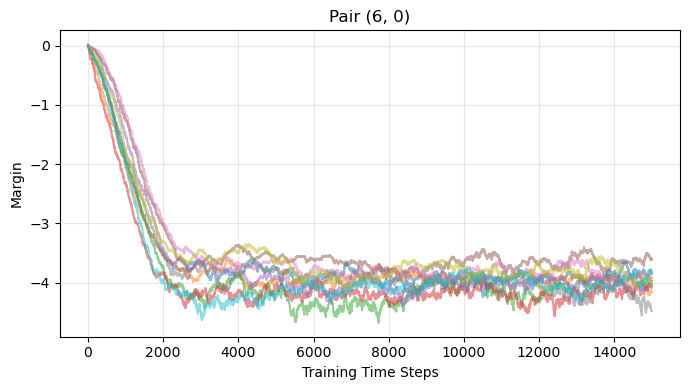

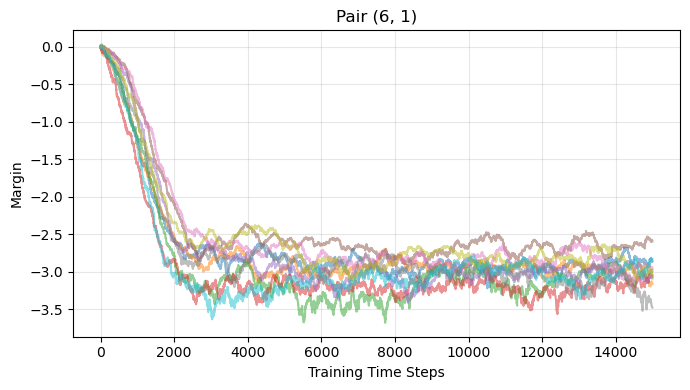

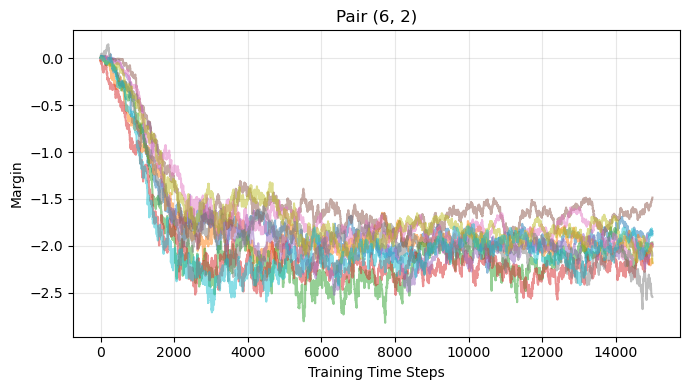

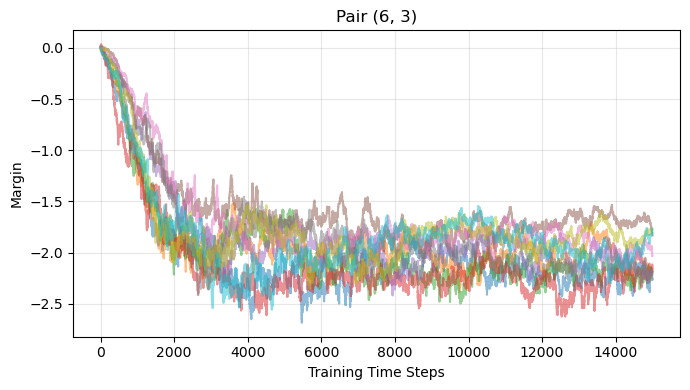

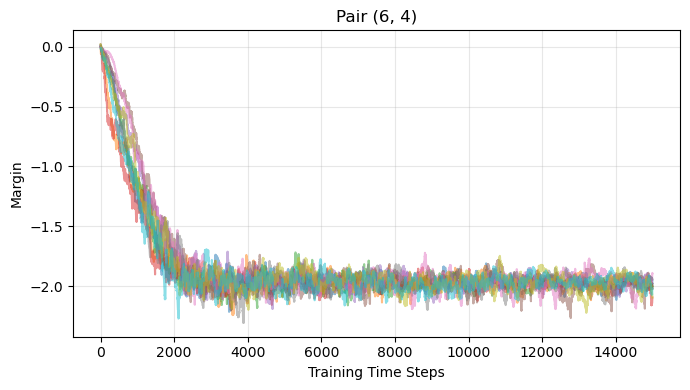

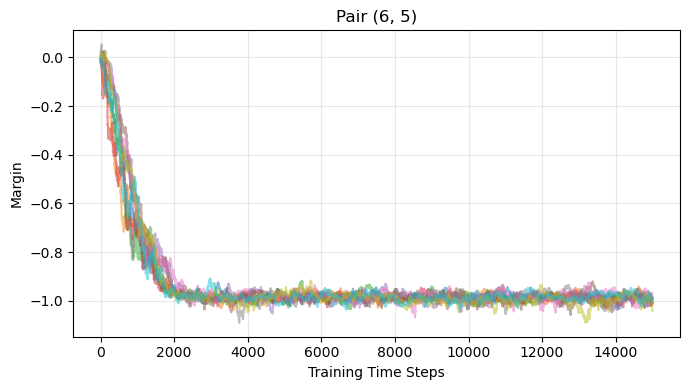

In [201]:
# Plot for every possible pair (i, j) in different figures
# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
training_progress = results["train"]["training_progress"]
seeds_n = training_progress.shape[0]
items_n = training_progress.shape[2]

for i in range(items_n):
    for j in range(items_n):
        if i == j:
            continue  # skip diagonal if desired
        plt.figure(figsize=(7,4))
        for seed in range(seeds_n):
            plt.plot(training_progress[seed, :14999, i, j], alpha=0.5)
        plt.xlabel("Training Time Steps")
        plt.ylabel("Margin")
        plt.title(f"Pair ({i}, {j})")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

Average margin grid (across seeds and final time):
[[ 1.29670393e-14  9.80734313e-01  1.96540302e+00  2.05357207e+00
   1.93508455e+00  2.93645446e+00  3.92607808e+00]
 [-9.90161824e-01  7.27060244e-14  9.84718579e-01  1.07313353e+00
   9.54262787e-01  1.95578256e+00  2.94534218e+00]
 [-1.98309839e+00 -9.92886752e-01 -1.16880286e-12  4.34398267e-02
  -5.05863091e-02  9.70851284e-01  1.96066674e+00]
 [-1.93222886e+00 -9.41771263e-01  6.14032075e-03 -2.16262975e-12
  -7.94103071e-03  8.83043927e-01  1.87260535e+00]
 [-1.99414754e+00 -1.00407322e+00 -3.13170012e-02  4.86277845e-02
  -1.56450569e-13  1.00001290e+00  1.99111750e+00]
 [-2.99794862e+00 -2.00772444e+00 -1.01505044e+00 -1.06555831e+00
  -1.00515814e+00 -2.77354176e-14  9.89648259e-01]
 [-3.99629073e+00 -3.00613050e+00 -2.01320068e+00 -2.06396258e+00
  -2.00201927e+00 -9.98317456e-01 -6.57543102e-14]]


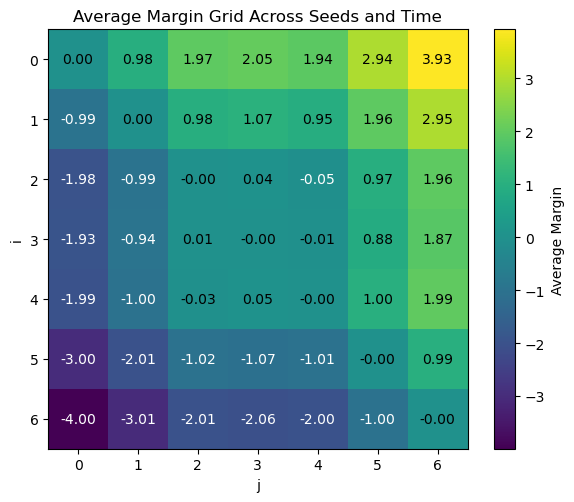

In [187]:
# Compute the average margin across seeds and time for each (i, j) pair
# Resulting in a grid of shape (items_n, items_n)
t_final = training_progress.shape[1] - 1
average_margin_grid = training_progress[:, t_final, :, :].mean(axis=0)
print("Average margin grid (across seeds and final time):")
print(average_margin_grid)

# Plot the average margin grid as a heatmap with values over each rectangle
plt.figure(figsize=(6, 5))
im = plt.imshow(average_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im, label="Average Margin")
plt.xlabel("j")
plt.ylabel("i")
plt.title("Average Margin Grid Across Seeds and Time")

# Add values in each cell
for i in range(average_margin_grid.shape[0]):
    for j in range(average_margin_grid.shape[1]):
        value = average_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()






Corrected average margin grid:
[[ 1.29670393e-14  9.80734313e-01  1.96540302e+00  2.05357207e+00
   1.93508455e+00  2.93645446e+00  3.92607808e+00]
 [ 9.90161824e-01  7.27060244e-14  9.84718579e-01  1.07313353e+00
   9.54262787e-01  1.95578256e+00  2.94534218e+00]
 [ 1.98309839e+00  9.92886752e-01 -1.16880286e-12  4.34398267e-02
   5.05863091e-02  9.70851284e-01  1.96066674e+00]
 [ 1.93222886e+00  9.41771263e-01 -6.14032075e-03 -2.16262975e-12
  -7.94103071e-03  8.83043927e-01  1.87260535e+00]
 [ 1.99414754e+00  1.00407322e+00 -3.13170012e-02 -4.86277845e-02
  -1.56450569e-13  1.00001290e+00  1.99111750e+00]
 [ 2.99794862e+00  2.00772444e+00  1.01505044e+00  1.06555831e+00
   1.00515814e+00 -2.77354176e-14  9.89648259e-01]
 [ 3.99629073e+00  3.00613050e+00  2.01320068e+00  2.06396258e+00
   2.00201927e+00  9.98317456e-01 -6.57543102e-14]]


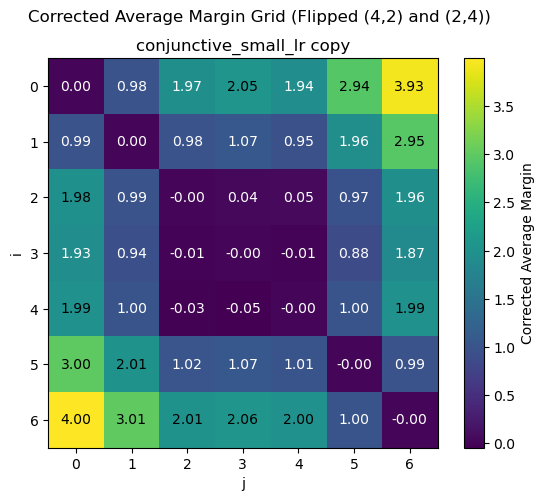

In [188]:
# Create a "correct" average margin grid where (4,2) and (2,4) entries are multiplied by -1, as well as if i>j
correct_margin_grid = average_margin_grid.copy()
correct_margin_grid[4, 2] *= -1
correct_margin_grid[2, 4] *= -1
for i in range(correct_margin_grid.shape[0]):
    for j in range(correct_margin_grid.shape[1]):
        if i>j and ( (i != 2 and j != 4) or (i != 4 and j != 2) ):
            correct_margin_grid[i,j] *= -1

print("Corrected average margin grid:")
print(correct_margin_grid)

# Plot the corrected average margin grid as a heatmap with values over each rectangle
plt.figure(figsize=(6, 5))
im_correct = plt.imshow(correct_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im_correct, label="Corrected Average Margin")
plt.xlabel("j")
plt.ylabel("i")
plt.suptitle("Corrected Average Margin Grid (Flipped (4,2) and (2,4))")
plt.title("conjunctive_small_lr copy")

# Add values in each cell
for i in range(correct_margin_grid.shape[0]):
    for j in range(correct_margin_grid.shape[1]):
        value = correct_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im_correct.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()



Sigmoid of corrected average margin grid:
[[0.5        0.7272539  0.87711649 0.88630806 0.87381113 0.94961937
  0.98066053]
 [0.72911988 0.5        0.72804348 0.74519237 0.72197165 0.8760758
  0.95004288]
 [0.87901106 0.72965773 0.5        0.51085825 0.51264388 0.72528914
  0.87660509]
 [0.87349592 0.71945731 0.49846492 0.5        0.49801475 0.7074526
  0.86675945]
 [0.88018124 0.73185867 0.49217139 0.48784545 0.5        0.73106111
  0.87986131]
 [0.95248137 0.88160571 0.73400736 0.74375131 0.73207152 0.5
  0.72901844]
 [0.98194816 0.95285032 0.88217611 0.88735087 0.88100893 0.73072764
  0.5       ]]


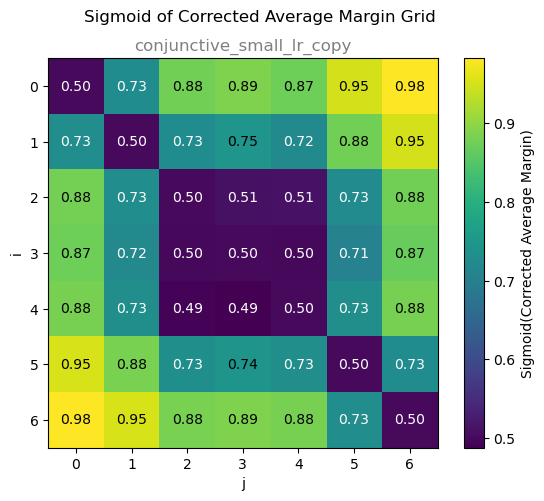

In [189]:
# Compute the sigmoid of the corrected average margin grid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid_correct_margin_grid = sigmoid(correct_margin_grid)

print("Sigmoid of corrected average margin grid:")
print(sigmoid_correct_margin_grid)

# Plot the sigmoid margin grid as a heatmap with values in each cell
plt.figure(figsize=(6, 5))
im_sigmoid_correct = plt.imshow(sigmoid_correct_margin_grid, cmap='viridis', interpolation='nearest')
plt.colorbar(im_sigmoid_correct, label="Sigmoid(Corrected Average Margin)")
plt.xlabel("j")
plt.ylabel("i")
plt.suptitle("Sigmoid of Corrected Average Margin Grid")
plt.title("conjunctive_small_lr_copy", color='gray')

# Add values in each cell
for i in range(sigmoid_correct_margin_grid.shape[0]):
    for j in range(sigmoid_correct_margin_grid.shape[1]):
        value = sigmoid_correct_margin_grid[i, j]
        plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='white' if im_sigmoid_correct.norm(value) < 0.5 else 'black')

plt.tight_layout()
plt.show()


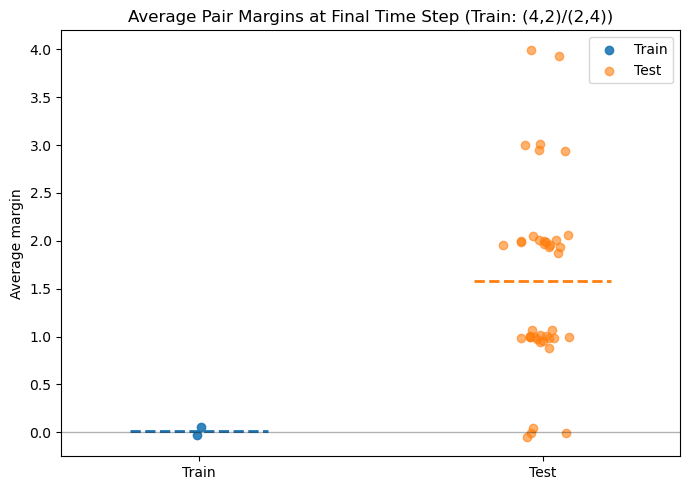

In [190]:
import numpy as np
import matplotlib.pyplot as plt

# Set your training pair (ensure p, q are defined as desired)
p, q = 4, 2

items_n = correct_margin_grid.shape[0]

# Masks: only (p,q) and (q,p) are training; test = all other off-diagonals
non_diag = ~np.eye(items_n, dtype=bool)
train_mask = np.zeros((items_n, items_n), dtype=bool)
train_mask[p, q] = True
train_mask[q, p] = True
test_mask = non_diag & ~train_mask

train_vals = correct_margin_grid[train_mask]
test_vals = correct_margin_grid[test_mask]

# Jittered x-positions for scatter
rng = np.random.default_rng(0)
x_train = rng.normal(loc=0, scale=0.05, size=train_vals.size)
x_test  = rng.normal(loc=1, scale=0.05, size=test_vals.size)

plt.figure(figsize=(7, 5))
plt.scatter(x_train, train_vals, color='C0', alpha=0.9, label='Train')
plt.scatter(x_test,  test_vals,  color='C1', alpha=0.6, label='Test')

# Optional: overlay means
plt.hlines(train_vals.mean(), -0.2, 0.2, colors='C0', linestyles='--', linewidth=2)
plt.hlines(test_vals.mean(),  0.8,  1.2, colors='C1', linestyles='--', linewidth=2)

plt.xticks([0, 1], ['Train', 'Test'])
plt.ylabel('Average margin')
plt.title(f'Average Pair Margins at Final Time Step (Train: ({p},{q})/({q},{p}))')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.4, 1.4)
plt.legend()
plt.tight_layout()
plt.show()

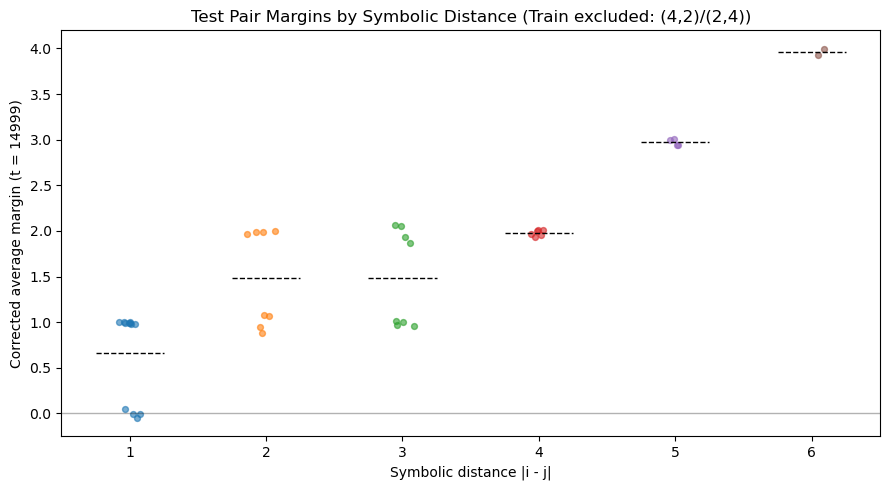

In [191]:
# Scatter of TEST pair margins grouped by symbolic distance |i - j|
# Assumes: correct_margin_grid, t_final, p, q are defined as above

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

# Exclude diagonal and training pair (p,q)/(q,p)
non_diag = ~np.eye(items_n, dtype=bool)
train_mask = np.zeros((items_n, items_n), dtype=bool)
train_mask[p, q] = True
train_mask[q, p] = True
test_mask = non_diag & ~train_mask

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

for d in range(1, items_n):
    vals = correct_margin_grid[(dist_mat == d) & test_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, label=None)
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

plt.xticks(range(1, items_n), [str(d) for d in range(1, items_n)])
plt.xlabel('Symbolic distance |i - j|')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title(f'Test Pair Margins by Symbolic Distance (Train excluded: ({p},{q})/({q},{p}))')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(0.5, items_n - 0.5)
plt.tight_layout()
plt.show()

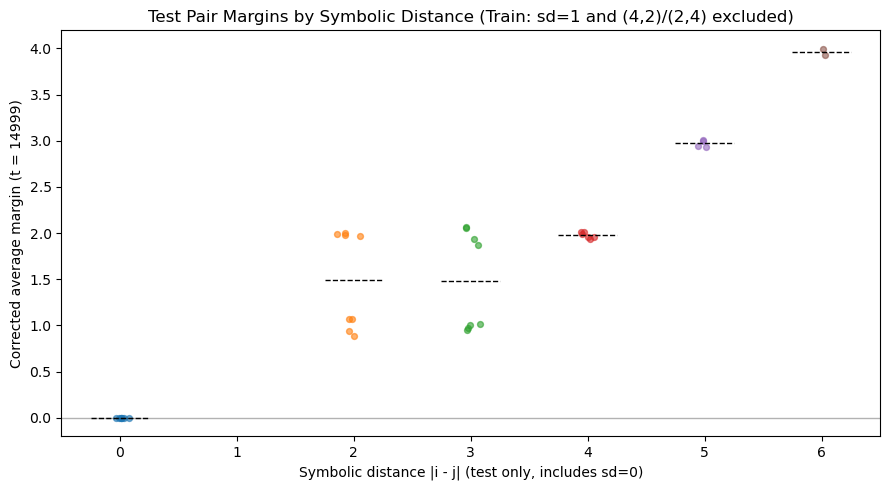

In [192]:
# Scatter of TEST pair margins grouped by symbolic distance |i - j|, including sd=0
# Assumes: correct_margin_grid, t_final, p, q are defined

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

# Training = all sd==1 pairs + the special pair (p,q)/(q,p)
training_mask = (dist_mat == 1)
training_mask[p, q] = True
training_mask[q, p] = True

# Test = everything else (including diagonal sd=0)
test_mask = ~training_mask

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

for d in range(0, items_n):
    vals = correct_margin_grid[(dist_mat == d) & test_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18)
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (test only, includes sd=0)')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title(f'Test Pair Margins by Symbolic Distance (Train: sd=1 and ({p},{q})/({q},{p}) excluded)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.tight_layout()
plt.show()

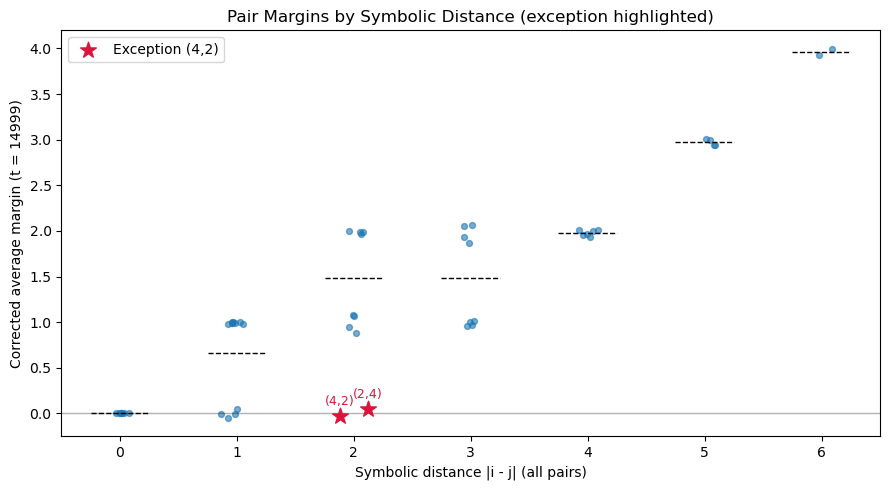

In [193]:
# Scatter of pair margins by symbolic distance |i - j| (including sd=0),
# highlighting the exception pair (p,q)/(q,p) with a distinct color and label.

import numpy as np
import matplotlib.pyplot as plt

items_n = correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

# Exclude the exception pair from the base scatter to avoid duplicate markers
base_mask = np.ones_like(dist_mat, dtype=bool)
base_mask[p, q] = False
base_mask[q, p] = False

# Plot all pairs grouped by symbolic distance (including sd=0 and sd=1)
for d in range(0, items_n):
    vals = correct_margin_grid[(dist_mat == d) & base_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, color='C0')
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

# Highlight the exception pair (p,q) and (q,p) at their symbolic distance
d_exc = abs(p - q)
y_pq = correct_margin_grid[p, q]
y_qp = correct_margin_grid[q, p]
plt.scatter(d_exc - 0.12, y_pq, color='crimson', marker='*', s=140, zorder=5, label=f'Exception ({p},{q})')
plt.scatter(d_exc + 0.12, y_qp, color='crimson', marker='*', s=140, zorder=5)

# Annotate the exception points
plt.annotate(f'({p},{q})', (d_exc - 0.12, y_pq), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)
plt.annotate(f'({q},{p})', (d_exc + 0.12, y_qp), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (all pairs)')
plt.ylabel('Corrected average margin (t = %d)' % t_final)
plt.title('Pair Margins by Symbolic Distance (exception highlighted)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.legend()
plt.tight_layout()
plt.show()

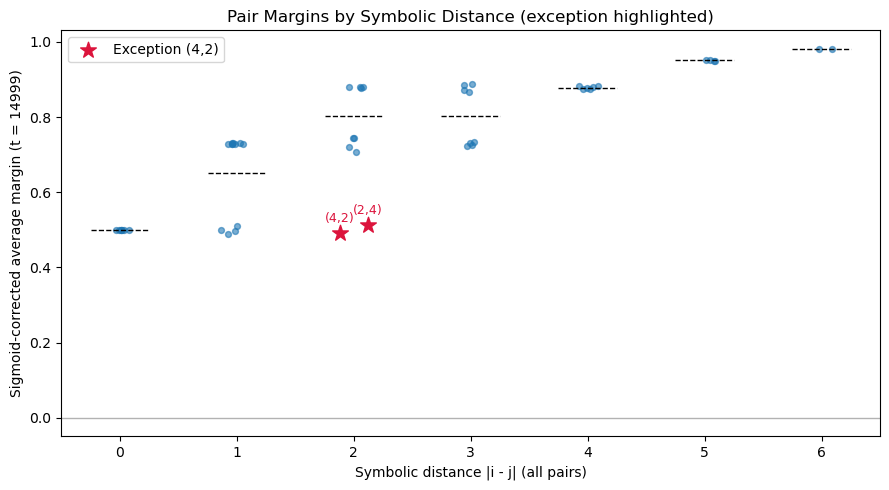

In [194]:
# Scatter of pair margins by symbolic distance |i - j| (including sd=0),
# highlighting the exception pair (p,q)/(q,p) using sigmoid_correct_margin_grid.

import numpy as np
import matplotlib.pyplot as plt

items_n = sigmoid_correct_margin_grid.shape[0]
I, J = np.indices((items_n, items_n))
dist_mat = np.abs(I - J)

plt.figure(figsize=(9, 5))
rng = np.random.default_rng(0)

# Exclude the exception pair from the base scatter to avoid duplicate markers
base_mask = np.ones_like(dist_mat, dtype=bool)
base_mask[p, q] = False
base_mask[q, p] = False

# Plot all pairs grouped by symbolic distance (including sd=0 and sd=1)
for d in range(0, items_n):
    vals = sigmoid_correct_margin_grid[(dist_mat == d) & base_mask]
    if vals.size == 0:
        continue
    x = rng.normal(loc=d, scale=0.06, size=vals.size)  # jitter around integer distance
    plt.scatter(x, vals, alpha=0.6, s=18, color='C0')
    mean_d = vals.mean()
    plt.hlines(mean_d, d - 0.25, d + 0.25, colors='k', linestyles='--', linewidth=1)

# Highlight the exception pair (p,q) and (q,p) at their symbolic distance
d_exc = abs(p - q)
y_pq = sigmoid_correct_margin_grid[p, q]
y_qp = sigmoid_correct_margin_grid[q, p]
plt.scatter(d_exc - 0.12, y_pq, color='crimson', marker='*', s=140, zorder=5, label=f'Exception ({p},{q})')
plt.scatter(d_exc + 0.12, y_qp, color='crimson', marker='*', s=140, zorder=5)

# Annotate the exception points
plt.annotate(f'({p},{q})', (d_exc - 0.12, y_pq), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)
plt.annotate(f'({q},{p})', (d_exc + 0.12, y_qp), textcoords='offset points', xytext=(0, 8),
             ha='center', color='crimson', fontsize=9)

plt.xticks(range(0, items_n), [str(d) for d in range(0, items_n)])
plt.xlabel('Symbolic distance |i - j| (all pairs)')
plt.ylabel('Sigmoid-corrected average margin (t = %d)' % t_final)
plt.title('Pair Margins by Symbolic Distance (exception highlighted)')
plt.axhline(0, color='k', linewidth=1, alpha=0.3)
plt.xlim(-0.5, items_n - 0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [195]:
import csv

# Extract training pair results and save to CSV
# We'll save the average margin over seeds for each pair (i, j) at each time step

# If results is a tuple, unpack it to get the actual results dict
if isinstance(results, tuple):
    results = results[1]
training_progress = results["train"]["training_progress"]  # shape: (seeds_n, time_steps, items_n, items_n)
seeds_n, time_steps, items_n, _ = training_progress.shape

# Prepare CSV header
header = ["time_step", "i", "j"] + [f"seed_{seed}" for seed in range(seeds_n)] + ["mean_margin", "std_margin"]

rows = []
for i in range(items_n):
    for j in range(items_n):
        for t in range(time_steps):
            margins = training_progress[:, t, i, j]
            mean_margin = margins.mean()
            std_margin = margins.std()
            row = [t, i, j] + list(margins) + [mean_margin, std_margin]
            rows.append(row)

# Write to CSV
# 'network' here refers to a variable defined earlier in the notebook, not to the class 'nellinetwork'.
csv_filename = f"conjunctive_lazy_rich.csv"
with open(csv_filename, mode="w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print(f"Training pair results saved to {csv_filename}")

print()


Training pair results saved to conjunctive_lazy_rich.csv



In [196]:
import pandas as pd

# Read the CSV file with training pair margins
df = pd.read_csv(csv_filename)

# Display the first few rows to verify extraction
print("Extracted results from CSV:")
print(df.head())

# Now 'df' contains the extracted results and can be used for further analysis or plotting


Extracted results from CSV:
   time_step  i  j        seed_0        seed_1        seed_2        seed_3  \
0          0  0  0  1.883929e-14 -7.234479e-16  4.226250e-17  7.738568e-15   
1          1  0  0  1.883999e-14 -7.224797e-16  4.383480e-17  7.737977e-15   
2          2  0  0  1.883698e-14 -7.235243e-16  4.340260e-17  8.543206e-15   
3          3  0  0  1.883415e-14 -7.241580e-16  4.176550e-17  8.258802e-15   
4          4  0  0  1.883404e-14 -1.790500e-16 -1.310100e-15  8.257767e-15   

         seed_4        seed_5        seed_6        seed_7        seed_8  \
0 -7.524777e-15  1.044676e-14  2.375494e-14 -1.554260e-15  2.012841e-15   
1 -7.527129e-15  1.044802e-14  2.375529e-14 -1.555099e-15  2.012416e-15   
2 -7.739232e-15  1.044884e-14  2.375481e-14 -1.556034e-15  2.013236e-15   
3 -7.429148e-15  1.044964e-14  2.375566e-14 -1.557465e-15  1.806590e-15   
4 -7.428668e-15  1.044844e-14  2.375533e-14 -1.558220e-15  1.603944e-15   

         seed_9   mean_margin    std_margin  
0  8.1

Figure out keyerror on t issue

In [197]:
import numpy as np

print("Columns in DataFrame:", df.columns.tolist())

# Try to find the correct time, i, j column names
# The original code expects 't', but the CSV uses 'time_step'
# Let's map accordingly
col_map = {}
for col in df.columns:
    if col.lower() in ['t', 'time', 'time_step']:
        col_map['t'] = col
    if col.lower() == 'i':
        col_map['i'] = col
    if col.lower() == 'j':
        col_map['j'] = col

# Use mapped column names
t_col = col_map.get('t', 'time_step')
i_col = col_map.get('i', 'i')
j_col = col_map.get('j', 'j')

df_sorted = df.sort_values([t_col, i_col, j_col]).reset_index(drop=True)

# The number of margin columns is seeds_n
margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
seeds_n = len(margin_cols)
time_steps = df[t_col].max() + 1  # assumes t is 0-based and contiguous
items_n = max(df[i_col].max(), df[j_col].max()) + 1  # assuming 0-based indexing

# Initialize training_progress array
training_progress = np.zeros((seeds_n, time_steps, items_n, items_n))

# Fill the array
for idx, row in df.iterrows():
    t = int(row[t_col])
    i = int(row[i_col])
    j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress[s, t, i, j] = row[col]

Columns in DataFrame: ['time_step', 'i', 'j', 'seed_0', 'seed_1', 'seed_2', 'seed_3', 'seed_4', 'seed_5', 'seed_6', 'seed_7', 'seed_8', 'seed_9', 'mean_margin', 'std_margin']


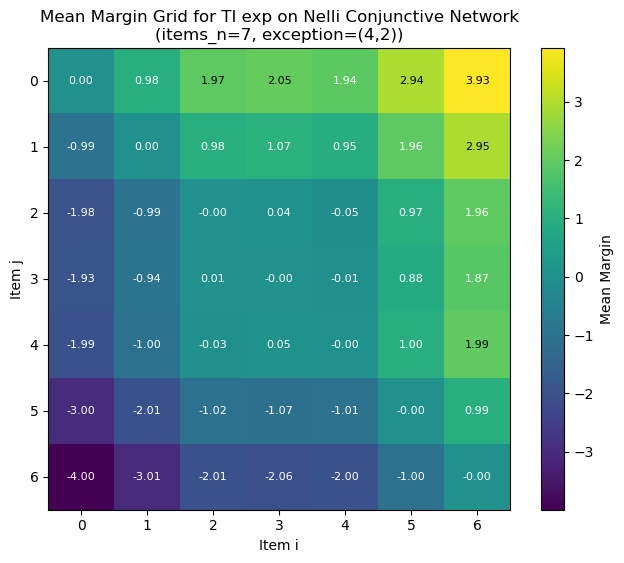

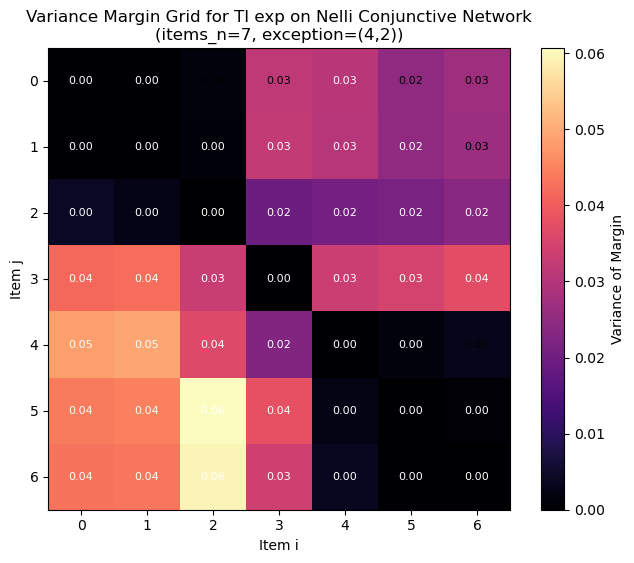

In [198]:
items_per_context = 7
p = 4
q = 2

if isinstance(results, tuple):
    results = results[1]
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, training_progress.shape[1]-1, i, j]
Average_Grid = np.mean(Grid, axis=0)
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Margin Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))

# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title(f'Variance Margin Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()


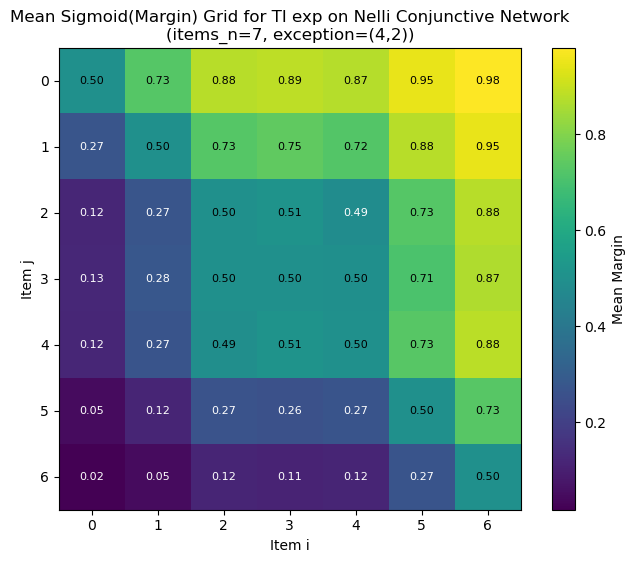

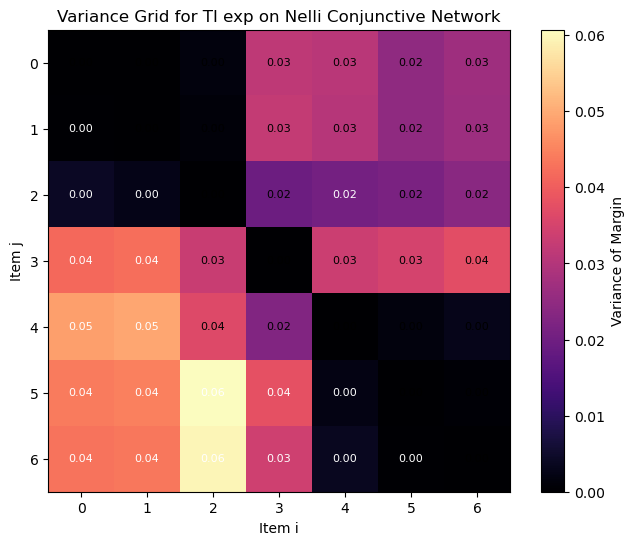

In [199]:
# if isinstance(results, tuple):
    # results = results[1]
# training_progress = results["train"]["training_progress"]
n = items_n
Grid = np.zeros((seeds_n, n, n))
for seed in range(seeds_n):
    for i in range(n):
        for j in range(n):
            Grid[seed, i, j] = training_progress[seed, training_length - 1, i, j]
Average_Grid = np.mean(Grid, axis=0)
# Apply sigmoid function to Average_Grid
Average_Grid = 1 / (1 + np.exp(-Average_Grid))
Std_Grid = np.var(Grid, axis=0)

plt.figure(figsize=(8, 6))
plt.imshow(Average_Grid, cmap='viridis', interpolation='none')
plt.colorbar(label='Mean Margin')
plt.title(f'Mean Sigmoid(Margin) Grid for TI exp on Nelli Conjunctive Network\n(items_n={items_n}, exception=({p},{q}))')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot mean numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Average_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(Std_Grid, cmap='magma', interpolation='none')
plt.colorbar(label='Variance of Margin')
plt.title('Variance Grid for TI exp on Nelli Conjunctive Network')
plt.xlabel('Item i')
plt.ylabel('Item j')
plt.xticks(range(n))
plt.yticks(range(n))
# Plot variance numbers over each square
for i in range(n):
    for j in range(n):
        plt.text(j, i, f"{Std_Grid[i, j]:.2f}", ha='center', va='center', color='white' if Average_Grid[i, j] < (Average_Grid.max() / 2) else 'black', fontsize=8)
plt.show()

In [200]:
# Plot each non-exception item vs each exception item
# Exception items: 2, 3, 4 (from p=4, q=2)
# Non-exception items: 0, 1, 5, 6

# Import MarginExtractor from parent directory
import sys
import os
import numpy as np

# Get the parent directory (where csv_margin.py should be)
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))

# If csv_margin.py is not in parent_dir, try current directory or set explicit path
if not os.path.exists(os.path.join(parent_dir, 'csv_margin.py')):
    # Check if it's in the current directory
    if os.path.exists(os.path.join(current_dir, 'csv_margin.py')):
        parent_dir = current_dir
    else:
        # Explicitly set to the Nelli Reimplementation directory
        parent_dir = r'Z:\Luke\Nelli Reimplementation'

print(f"Current directory: {current_dir}")
print(f"Using directory: {parent_dir}")
print(f"csv_margin.py exists: {os.path.exists(os.path.join(parent_dir, 'csv_margin.py'))}")

if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
    
from csv_margin import MarginExtractor
import pandas as pd

# Load the CSV file that was already created
csv_filename = "conjunctive_lazy_rich.csv"
df = pd.read_csv(csv_filename)

# Reconstruct training_progress from CSV (same as Cell 27)
t_col = 'time_step'
i_col = 'i'
j_col = 'j'

margin_cols = [col for col in df.columns if col not in [t_col, i_col, j_col, 'mean_margin', 'std_margin']]
csv_seeds_n = len(margin_cols)
csv_time_steps = df[t_col].max() + 1
csv_items_n = max(df[i_col].max(), df[j_col].max()) + 1

# Initialize training_progress array from CSV
training_progress_from_csv = np.zeros((csv_seeds_n, csv_time_steps, csv_items_n, csv_items_n))

# Fill the array
for idx, row in df.iterrows():
    t = int(row[t_col])
    i = int(row[i_col])
    j = int(row[j_col])
    for s, col in enumerate(margin_cols):
        training_progress_from_csv[s, t, i, j] = row[col]

# Create a mock results dict for MarginExtractor
results_from_csv = {
    "train": {
        "training_progress": training_progress_from_csv
    }
}

# Create MarginExtractor from CSV data
extractor = MarginExtractor(results_from_csv)
print(f"Loaded data from CSV: {csv_seeds_n} seeds, {csv_time_steps} timesteps, {csv_items_n} items")

# Define exception and non-exception items
p, q = 4, 2
exception_items = list(range(min(p, q), max(p, q) + 1))  # [2, 3, 4]
all_items = list(range(items_n))
non_exception_items = [i for i in all_items if i not in exception_items]

print(f"Exception items: {exception_items}")
print(f"Non-exception items: {non_exception_items}")

# Plot each non-exception item against each exception item
for non_exc in non_exception_items:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Item {non_exc} vs Exception Items", fontsize=14, fontweight='bold')
    
    for idx, exc in enumerate(exception_items):
        ax = axes[idx]
        
        # Plot margin over time for each seed
        for seed in range(seeds_n):
            # Get margin for (non_exc, exc)
            margin_data = extractor.training_progress[seed, :, non_exc, exc]
            ax.plot(margin_data, alpha=0.5, linewidth=1)
        
        # Calculate mean and plot
        mean_margin = extractor.training_progress[:, :, non_exc, exc].mean(axis=0)
        ax.plot(mean_margin, color='black', linewidth=2, label='Mean', linestyle='--')
        
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Margin')
        ax.set_title(f'({non_exc}, {exc})')
        ax.grid(True, alpha=0.3)
        ax.axhline(y=0, color='red', linestyle=':', linewidth=1, alpha=0.5)
        
    axes[0].legend()
    plt.tight_layout()
    plt.show()


Current directory: /share/ctn/users/lc3616/Nelli Reimplementation/conjunctive_lazy_rich_1e-6
Using directory: /share/ctn/users/lc3616/Nelli Reimplementation
csv_margin.py exists: True


KeyboardInterrupt: 

In [ ]:
# Scatterplot version - showing final margins for non-exception vs exception items
# Reuse the same exception/non-exception item definitions

# Get final timestep margins
final_timestep = extractor.time_steps - 1

for non_exc in non_exception_items:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Item {non_exc} vs Exception Items (Final Margins - Scatterplot)", fontsize=14, fontweight='bold')
    
    for idx, exc in enumerate(exception_items):
        ax = axes[idx]
        
        # Get final margins for all seeds for pair (non_exc, exc)
        final_margins = extractor.training_progress[:, final_timestep, non_exc, exc]
        
        # Create scatter plot with seed indices on x-axis
        seeds = np.arange(csv_seeds_n)
        ax.scatter(seeds, final_margins, s=100, alpha=0.7, c='steelblue', edgecolors='black', linewidth=1)
        
        # Add mean line
        mean_margin = final_margins.mean()
        ax.axhline(y=mean_margin, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_margin:.3f}')
        
        # Add zero reference line
        ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        
        ax.set_xlabel('Seed')
        ax.set_ylabel('Final Margin')
        ax.set_title(f'({non_exc}, {exc})')
        ax.set_xticks(seeds)
        ax.grid(True, alpha=0.3)
        ax.legend()
        
    plt.tight_layout()
    plt.show()


In [ ]:
# Combined scatter plot: all non-exception items vs exception items in one figure
# X-axis: exception item index (2, 3, 4)
# Y-axis: final margin values (one point per seed)

import numpy as np
import matplotlib.pyplot as plt

# Get final timestep margins
final_timestep = extractor.time_steps - 1
rng = np.random.default_rng(0)

# Create a 2x2 subplot grid for all non-exception items
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to easily iterate

fig.suptitle('Non-Exception Items vs Exception Items (All Seeds)', fontsize=16, fontweight='bold')

# Create a plot for each non-exception item
for idx, non_exc_item in enumerate(non_exception_items):
    ax = axes[idx]
    
    for exc in exception_items:
        # Get final margins for all seeds for pair (non_exc_item, exc)
        final_margins = extractor.training_progress[:, final_timestep, non_exc_item, exc]
        
        # Correct margins: multiply by -1 if i > j
        if non_exc_item > exc:
            final_margins = -1 * final_margins
        
        # Add jitter to x-coordinates for visibility
        x = rng.normal(loc=exc, scale=0.06, size=final_margins.size)
        ax.scatter(x, final_margins, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        # Add mean line with label
        mean_margin = final_margins.mean()
        ax.hlines(mean_margin, exc - 0.25, exc + 0.25, colors='red', linestyles='--', linewidth=2)
        ax.text(exc, mean_margin, f'{mean_margin:.2f}', ha='center', va='bottom', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8))
    
    ax.set_xticks(exception_items)
    ax.set_xticklabels([str(e) for e in exception_items])
    ax.set_xlabel('Exception Item')
    ax.set_ylabel('Final Margin')
    ax.set_title(f'Corrected Margin on Item {non_exc_item} vs Exception Items', fontweight='bold')
    ax.axhline(0, color='gray', linewidth=1, linestyle=':', alpha=0.5)
    ax.set_xlim(min(exception_items) - 0.5, max(exception_items) + 0.5)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [ ]:
# Combined scatter plot with SIGMOID(corrected margins)
# X-axis: exception item index (2, 3, 4)
# Y-axis: sigmoid of final margin values (one point per seed)

import numpy as np
import matplotlib.pyplot as plt

# Get final timestep margins
final_timestep = extractor.time_steps - 1
rng = np.random.default_rng(0)

# Create a 2x2 subplot grid for all non-exception items
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to easily iterate

fig.suptitle('Non-Exception Items vs Exception Items - Sigmoid(Corrected Margin) (Prop=1e-6)', fontsize=16, fontweight='bold')

# Create a plot for each non-exception item
for idx, non_exc_item in enumerate(non_exception_items):
    ax = axes[idx]
    
    for exc in exception_items:
        # Get final margins for all seeds for pair (non_exc_item, exc)
        final_margins = extractor.training_progress[:, final_timestep, non_exc_item, exc]
        
        # Correct margins: multiply by -1 if i > j
        if non_exc_item > exc:
            final_margins = -1 * final_margins
        
        # Apply sigmoid transformation
        final_margins_sigmoid = 1 / (1 + np.exp(-final_margins))
        
        # Add jitter to x-coordinates for visibility
        x = rng.normal(loc=exc, scale=0.06, size=final_margins_sigmoid.size)
        ax.scatter(x, final_margins_sigmoid, alpha=0.6, s=60, edgecolors='black', linewidth=0.5)
        
        # Add mean line with label
        mean_margin = final_margins_sigmoid.mean()
        ax.hlines(mean_margin, exc - 0.25, exc + 0.25, colors='red', linestyles='--', linewidth=2)
        ax.text(exc, mean_margin, f'{mean_margin:.3f}', ha='center', va='bottom', fontsize=8, 
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='red', alpha=0.8))
    
    ax.set_xticks(exception_items)
    ax.set_xticklabels([str(e) for e in exception_items])
    ax.set_xlabel('Exception Item')
    ax.set_ylabel('Sigmoid(Corrected Margin)')
    ax.set_title(f'Item {non_exc_item} vs Exception Items', fontweight='bold')
    ax.axhline(0.5, color='gray', linewidth=1, linestyle=':', alpha=0.5, label='Decision boundary')
    ax.set_xlim(min(exception_items) - 0.5, max(exception_items) + 0.5)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3, axis='y')
    if idx == 0:
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()
